# Ecuación de Poisson en Coordenadas Polares

La resolución de ecuaciones diferenciales no está limitada por supuesto al plano cartesiano. Una aplicación interesante es resolver la Ecuación de Poisson en coordenadas polares. Note que las condiciones de borde pueden escribirse de la manera tradicional. Con lo que sí debemos tener cuidado es con la definición del Laplaciano en estas coordenadas.
\begin{align*}
\Delta u &= f\\
u(r, \theta_a) &= g_1(r)\\
u(r_a, \theta) &= g_2(\theta)\\
u(r, \theta_b) &= g_3(r)\\
u(r_b, \theta) &= g_4(\theta)\\
\end{align*}

El Laplaciano toma la siguiente forma:
$$\Delta u = u_{rr} + \frac{1}{r}u_r + \frac{1}{r^2}u_{\theta\theta}$$

Por lo tanto en nuestra indexación para construir la matriz de coeficientes $A$ hay que incluir estos nuevos términos, como ya se ha estudiado, mediante diferencias finitas. Notar que los términos que dependen explícitamente de $r$ deben ser reemplazados por sus versiones discretas $i\cdot \Delta r$.

### Preguntas interesantes:
1. Discretice el sistema mediante diferencias finitas centradas (¿por qué no simplemente *forward difference* para $u_r$?).
2. Encuentre, según la indexación lineal para resolver este tipo de ecuaciones, los términos de la matriz de coeficientes $A$ a partir de los términos provenientes del esquema cartesiano.
3. Qué sucede si se elije r=0

In [26]:
import numpy as np
from scipy.integrate import fixed_quad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

In [66]:
def poisson_equation_polar(ri, ro, yi, yf, M, N):
    """
        Solving Poisson Equation with Neumann Conditions over two boundaries.
        Args:
            [ri, ro]:          Space interval R (inner radius, outer radius)
            [yi, yf]:          Space interval Y (Initial and final angles)
            M, N:              Space steps
            f:                 Condition imposed for \Delta u = f
    """
    # Step sizes
    h, k = (ro-ri)/M, (yf-yi)/N
    m, n = M+1, N+1
    rr = np.linspace(ri, ro, m)
    yy = np.linspace(yi, yf, n)
    # Boundary conditions, it's easier for me to modify inside the solver
    f = lambda r, y: 0
    # Boundary condition for yi
    g1 = lambda r: 0
    # Boundary condition for ro
    g2 = lambda y: np.sin(3*y)
    # Boundary condition for yf
    g3 = lambda r: 0
    # Boundary condition for ri
    g4 = lambda y: 0
    # Finite differences matrix
    A = np.zeros((m*n, m*n))
    b = np.zeros((m*n, 1))
    
    # Define global indexing, useful for linearize the matrix per row!
    idx = lambda i, j: i + j*m
    for i in range(m):
        for j in range(n):
            p = idx(i,j)
            if j == 0:
                A[p,p] = 1.
                b[p] = g1(rr[i])
            elif i == M:
                A[p,p] = 1.
                b[p] = g2(yy[j])
            elif j == N:
                A[p,p] = 1.
                b[p] = g3(rr[i])
            elif i == 0:
                A[p,p] = 1.
                b[p] = g4(yy[j])
            else:
                A[p,p] = -2./h**2 - 2./(i*h*k)**2.
                A[p,idx(i+1,j)] = (1.+1./(2.*i))/h**2.
                A[p,idx(i-1,j)] = (1.-1./(2.*i))/h**2.
                A[p,idx(i,j-1)] = 1./(i*h*k)**2.
                A[p,idx(i,j+1)] = 1./(i*h*k)**2.
                b[p] = f(rr[i], yy[j])
    print("Cond(A)=%f" % (np.linalg.cond(A)))
    W = np.linalg.solve(A,b)
    print("System solved.")
    return (rr, yy, W.reshape(m, n))

Cond(A)=341694.375059
System solved.


<IPython.core.display.Javascript object>


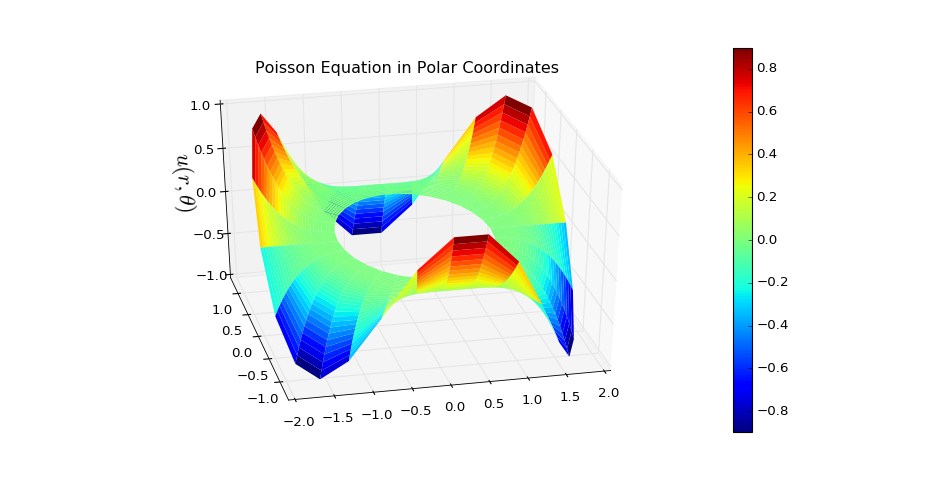

In [68]:
ri, ro, yi, yf = 1., 2., 0, 2*np.pi
M, N = 30, 30
rr, yy, W = poisson_equation_polar(ri, ro, yi, yf, M, N)
[R, Y] = np.meshgrid(rr, yy)
X, Y = R*np.cos(Y), R*np.sin(Y)
# Plot results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_xlabel(r"$x$", fontsize=20)
#ax.set_ylabel(r"$y$", fontsize=20)
ax.set_zlabel(r"$u(r,\theta)$", fontsize=20)
ax.set_title("Poisson Equation in Polar Coordinates")
surface = ax.plot_surface(X, Y, W, cmap=cm.jet, linewidth=0, antialiased=True, rstride=1, cstride=1)
fig.colorbar(surface)
plt.axis('equal')
plt.draw()

## Disclaimer

El presente notebook ha sido creado para el curso ILI286 - Computación Científica 2, del Departamento de Informática, Universidad Técnica Federico Santa María. El material ha sido creado por Alejandro Sazo (asazo@alumnos.inf.utfsm.cl). En caso de encontrar un error, por favor no dude en contactar al email especificado. Puede encontrar la última versión del código en https://github.com/asazo/CC2